In [46]:
import pickle
with open('./outs/CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/COexps.pkl', 'rb') as f:
    COexps = pickle.load(f)
with open('./outs/HIexps.pkl', 'rb') as f:
    HIexps = pickle.load(f)
with open('./outs/GALexps.pkl', 'rb') as f:
    GALexps = pickle.load(f)

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

REDSHIFT = Z_MODELING[2]
print(f"Redshift: {REDSHIFT}")

Redshift: 1.173


In [2]:
lineexps = CIIexps
ps = "ps_cii"
PSCOLOR = 'midnightblue'#'crimson'#'brown'# ##
print(lineexps.keys())

dict_keys(['PTIM_1', 'TIM_NG', 'SpTIM_100'])


In [31]:
lineexps = COexps
ps = "ps_co"
PSCOLOR = 'brown'#'crimson'#'brown'# ##
print(lineexps.keys())

dict_keys(['7OT-EoRSpec', 'DSS-EoRSpec', 'OCS-EoRSpec', 'FullDSS-EoRSpec'])


In [32]:
import numpy as np

combos = {"ps_cii": ['PTIM_1', 'TIM_NG', 'SpTIM_100'],
        "ps_hi": ['MeerKAT_1_1000', 'MeerKAT_4_3000', 'SKA-Mid_100_5000'],
        "ps_co": ['DSS-EoRSpec', 'FullDSS-EoRSpec', '7OT-EoRSpec', 'OCS-EoRSpec']}[ps]

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psauto = [data[ps] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psautomedian = [np.median(pscii, axis=0)[1:-1] for pscii in psauto]
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psauto]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psauto]
autoexps = {}

for cii_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = lineexps[cii_key]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_cii]
    Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psautomedian, Pn_cii, binned_total_cii, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    autoexps[f'{cii_key}'] = (KSs, psautomedian, Pstd, Nmodes, Pn_cii, label_cii + ' auto')

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_61391/1786976712.py:28: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psautomedian, Pn_cii, binned_total_cii, Nmodes)]


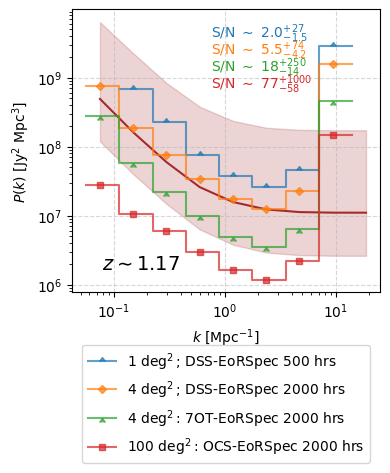

In [35]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(4, 5))
ax = axs
i = 2
markers = [10, 'D', 6] if ps != "ps_co" else [10, 'D', 6, 's']

# labels = [
#     r"1 $\deg^2$; TIM 200 hrs",
#     r"4 $\deg^2$: CryoTIM 200 hrs",
#     r"100 $\deg^2$: SpaceTIM 1000 hrs"
# ]

# labels = [
#     r"1 $\deg^2$; MeerKAT 1000 hrs",
#     r"4 $\deg^2$: MeerKAT 3000 hrs",
#     r"100 $\deg^2$: SKA-Mid 5000 hrs"
# ]

labels = [
    r"1 $\deg^2$; DSS-EoRSpec 500 hrs",
    r"4 $\deg^2$; DSS-EoRSpec 2000 hrs",
    r"4 $\deg^2$: 7OT-EoRSpec 2000 hrs",
    r"100 $\deg^2$: OCS-EoRSpec 2000 hrs"
]
    

for ax in [axs]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.grid(linestyle='--', alpha=0.5)

axs.set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]')


ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
ax.plot(KSs[i][1:-1], psautomedian[i], color=PSCOLOR)
    
for j, exp in enumerate(autoexps.values()):
    linestyle = 'solid'
    if i == 3:
        # do not plot MeerKAT curves
        if 'MeerKAT' in labels[j]:
            linestyle = 'dotted'
    KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, label = exp
    SNR = psCIIxCO_exp[i] / Pstd_exp[i]
    SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
    SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
    SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
    SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if s > 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
    
    # all_snrs[f"{ps} auto" + labels[j] + f" z={Z_MODELING[i]:.2f}"] = (SNR, SNRlow, SNRhigh)
    
    snrtext = r'S/N $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
    
    
    _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], \
        marker=markers[j], markersize=4, alpha=0.7, color=f'C{j}', linestyle=linestyle)
    
    # ax.text(.55, .32-.06*j, snrtext, color=f'C{j}', transform=ax.transAxes)
    ax.text(.45, .9-.06*j, snrtext, color=f'C{j}', transform=ax.transAxes)
ax.text(.35, .08, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

axs.legend(bbox_to_anchor=(0.5, -.16), loc='upper center', fontsize=10, ncol=1)

# plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [54]:
import pickle
cross_exps = {}
with open('./outs/COexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/GALexps.pkl', 'rb') as f:
    GALexps = pickle.load(f)

crosskey = 'ps_cross_coxgalaxy'

In [55]:
# combos = [
#     ('PTIM_1', 'Euclid_1'),
#     ('TIM_NG', 'Euclid_4'),
#     ('SpTIM_100', 'Euclid_100')]

combos = [
    ('DSS-EoRSpec', 'Euclid_1'),
    ('FullDSS-EoRSpec', 'Euclid_4'),
    ('7OT-EoRSpec', 'Euclid_4'),
    ('OCS-EoRSpec', 'Euclid_100')]

# combos = [
#     ('PTIM_1', 'Euclid_1'),
#     ('PTIM_1_Nmodes_ones', 'Euclid_1'),
#     ]

# combos = [
#     ('MeerKAT_1_1000', 'Euclid_1'),
#     ('MeerKAT_4_3000', 'Euclid_4'),
#     ('SKA-Mid_100_5000', 'Euclid_100')]

bands = ['SW', 'SW', 'LW', 'LW']

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCIIxCO = [data[crosskey] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

In [56]:
for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = GALexps[co_key]
    
    # Nmodes = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes_kmu = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_kmu]
    # do not apply window for galaxy survey
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_61391/3949055607.py:9: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


In [57]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

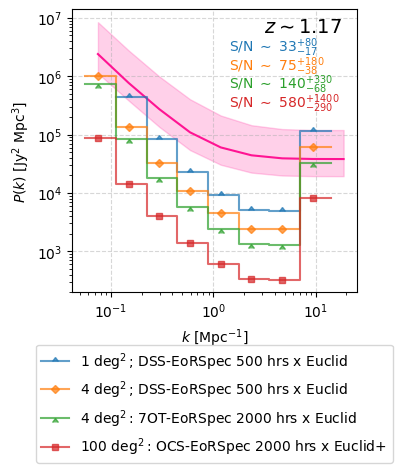

In [60]:
fig, axs = plt.subplots(1, 1, figsize=(4, 5))
# axs = axs.flatten()
ax = axs
i = 2
PSCOLOR = 'deeppink' #'orange'  #'cyan'
markers = [10, 'D', 6] if ps != "ps_co" else [10, 'D', 6, 's']

# labels = [
#     r"1 $\deg^2$; TIM 200 hrs x Euclid",
#     r"4 $\deg^2$: CryoTIM 200 hrs x Euclid",
#     r"100 $\deg^2$: SpaceTIM 1000 hrs x Euclid+"
# ]

labels = [
    r"1 $\deg^2$; DSS-EoRSpec 500 hrs x Euclid",
    r"4 $\deg^2$; DSS-EoRSpec 500 hrs x Euclid",
    r"4 $\deg^2$: 7OT-EoRSpec 2000 hrs x Euclid",
    r"100 $\deg^2$: OCS-EoRSpec 2000 hrs x Euclid+"
]

# labels = [
#     r"1 $\deg^2$; MeerKAT 1000 hrs x Euclid",
#     r"4 $\deg^2$: MeerKAT 3000 hrs x Euclid",
#     r"100 $\deg^2$: SKA-Mid 5000 hrs x Euclid+"
# ]

# labels = [
#     r"1 $\deg^2$; PTIM 200 hrs x Euclid",
#     r"1 $\deg^2$; PTIM 200 hrs x Euclid (Nmodes ones)"
# ]

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.grid(linestyle='--', alpha=0.5)

ax.set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]')

ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR)
    
for j, exp in enumerate(cross_exps.values()):
    linestyle = 'solid'
    if i == 3:
        # do not plot MeerKAT curves
        if 'MeerKAT' in labels[j]:
            linestyle = 'dotted'
    KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
    _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], \
        marker=markers[j], markersize=4, alpha=0.7, color=f'C{j}', linestyle=linestyle)
    SNR = psCIIxCO_exp[i] / Pstd_exp[i]
    SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
    SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
    SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
    SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
    
    # all_snrs[f"HIxGAL" + labels[j] + f" z={Z_MODELING[i]:.2f}"] = (SNR, SNRlow, SNRhigh)
    
    snrtext = r'S/N $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
    ax.text(.55, .85-.065*j, snrtext, color=f'C{j}', transform=ax.transAxes)
ax.text(.95, .92, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

ax.legend(bbox_to_anchor=(0.5, -.16), loc='upper center', fontsize=10, ncol=1)

plt.tight_layout()
plt.show()
plt.close()

In [61]:
import pickle
cross_exps = {}
with open('./outs/HIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/COexps.pkl', 'rb') as f:
    COexps = pickle.load(f)

print(CIIexps.keys())
print(COexps.keys())

dict_keys(['SKA-Mid_100_5000', 'MeerKAT_4_3000', 'MeerKAT_1_1000'])
dict_keys(['7OT-EoRSpec', 'DSS-EoRSpec', 'OCS-EoRSpec', 'FullDSS-EoRSpec'])


In [62]:
combos = [
    ('MeerKAT_1_1000', 'DSS-EoRSpec'),
    ('MeerKAT_4_3000', 'FullDSS-EoRSpec'),
    ('MeerKAT_4_3000', '7OT-EoRSpec'),
    ('SKA-Mid_100_5000', 'OCS-EoRSpec')]

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCIIxCO = [data['ps_cross_coxhi'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = COexps[co_key]
    
    # Nmodes = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes_kmu = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_kmu]
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_61391/965039348.py:28: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


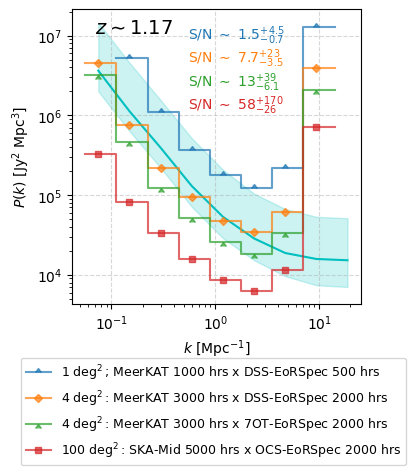

In [ ]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

fig, axs = plt.subplots(1, 1, figsize=(4, 5), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
# axs = axs.flatten()
i = 2
ax = axs
PSCOLOR = 'c'
markers = [10, 'D', 6, 's']

labels = [
    r"1 $\deg^2$; MeerKAT 1000 hrs x DSS-EoRSpec 500 hrs",
    r"4 $\deg^2$: MeerKAT 3000 hrs x DSS-EoRSpec 2000 hrs",
    r"4 $\deg^2$: MeerKAT 3000 hrs x 7OT-EoRSpec 2000 hrs",
    r"100 $\deg^2$: SKA-Mid 5000 hrs x OCS-EoRSpec 2000 hrs"
]

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.grid(linestyle='--', alpha=0.5)

ax.set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]')
colors = ['C0', 'C1', 'C2', 'C3']

ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR)
    
for j, exp in enumerate(cross_exps.values()):
    linestyle = 'solid'
    if i == 3:
        # do not plot MeerKAT curves
        if 'MeerKAT' in labels[j]:
            linestyle = 'dotted'
    KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
    _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], \
        marker=markers[j], markersize=4, alpha=0.7, color=colors[j], linestyle=linestyle)
    SNR = psCIIxCO_exp[i] / Pstd_exp[i]
    SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
    SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
    SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
    SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if s>1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
    
    snrtext = r'S/N $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
    
    # all_snrs[f"COxHI" + labels[j] + f" z={Z_MODELING[i]:.2f}"] = (SNR, SNRlow, SNRhigh)
    if i != 2:
        ax.text(.55, .9-.08*j, snrtext, color=f'C{j}', transform=ax.transAxes)
    else:
        ax.text(.4, .9-.08*j, snrtext, color=f'C{j}', transform=ax.transAxes)
ax.text(.35, .92, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

ax.legend(bbox_to_anchor=(-.2, -.16), loc='upper left', fontsize=9, ncol=1)

plt.tight_layout()
plt.show()
plt.close()

In [84]:
import pickle
cross_exps = {}
with open('./outs/CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/COexps.pkl', 'rb') as f:
    COexps = pickle.load(f)

print(CIIexps.keys())
print(COexps.keys())

dict_keys(['PTIM_1', 'TIM_NG', 'SpTIM_100'])
dict_keys(['7OT-EoRSpec', 'DSS-EoRSpec', 'OCS-EoRSpec', 'FullDSS-EoRSpec'])


In [85]:
combos = [
    ('PTIM_1', 'DSS-EoRSpec'),
    ('TIM_NG', 'FullDSS-EoRSpec'),
    ('TIM_NG', '7OT-EoRSpec'),
    ('SpTIM_100', 'OCS-EoRSpec')]

bands = ['SW', 'LW', 'SW', 'LW']

import pickle
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCIIxCO = [data['ps_cross_ciixco'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

In [86]:
for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = COexps[co_key]
    
    Nmodes_kmu = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_kmu]
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_61391/3166113335.py:7: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


In [87]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]


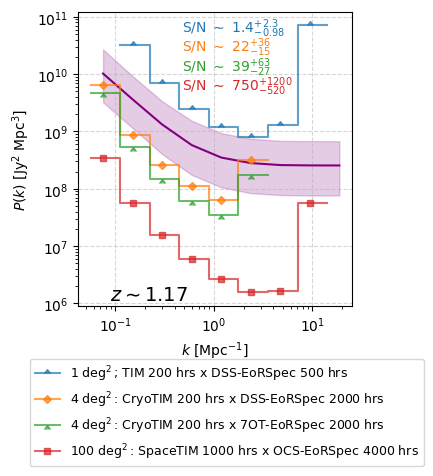

In [97]:

fig, axs = plt.subplots(1, 1, figsize=(4, 5), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
# axs = axs.flatten()
ax = axs
i = 2
PSCOLOR = 'purple'
markers = [10, 'D', 6, 's']

# 'DSS-EoRSpec', '7OT-EoRSpec', 'OCS-EoRSpec'
# labels = [
#     r"1 $\deg^2$; TIM 200 hrs x EoRSpec 500 hrs",
#     r"4 $\deg^2$: CryoTIM 200 hrs x EoRSpec 2000 hrs",
#     r"100 $\deg^2$: SpaceTIM 1000 hrs x EoRSpec 4000 hrs"
# ]
labels = [
    r"1 $\deg^2$; TIM 200 hrs x DSS-EoRSpec 500 hrs",
    r"4 $\deg^2$: CryoTIM 200 hrs x DSS-EoRSpec 2000 hrs",
    r"4 $\deg^2$: CryoTIM 200 hrs x 7OT-EoRSpec 2000 hrs",
    r"100 $\deg^2$: SpaceTIM 1000 hrs x OCS-EoRSpec 4000 hrs"
]

ax.set_xscale('log') 
ax.set_yscale('log')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.grid(linestyle='--', alpha=0.5)

ax.set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]')

ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR)
    
for j, exp in enumerate(cross_exps.values()):
    KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
    _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], marker=markers[j], markersize=4, alpha=0.7)
    SNR = psCIIxCO_exp[i] / Pstd_exp[i]
    SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
    SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
    SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
    SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if s > 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
    
    # all_snrs["CIIxCO" + labels[j] + f" z={Z_MODELING[i]:.2f}"] = (SNR, SNRlow, SNRhigh)
    
    snrtext = r'S/N $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
    ax.text(.38, .93-.065*j, snrtext, color=f'C{j}', transform=ax.transAxes)
ax.text(.4, .02, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

ax.legend(bbox_to_anchor=(-.2, -.16), loc='upper left', fontsize=9, ncol=1)

plt.tight_layout()
plt.show()
plt.close()